<a href="https://colab.research.google.com/github/AlyssaAmod/UNN_BraTS23/blob/main/Augmentations_Efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install synapseclient

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.3/218.3 kB 2.8 MB/s eta 0:00:00
  Attempting uninstall: keyring
    Found existing installation: keyring 23.5.0
    Uninstalling keyring-23.5.0:
      Successfully uninstalled keyring-23.5.0


In [3]:
import synapseclient
syn = synapseclient.Synapse()
syn.login(email='pearlyjoubert2@gmail.com', password='SPARK_BRATS_2023')
SSA = syn.get("syn51692615")
GLI = syn.get("syn51514132")
# creating file path
SSA_path = SSA.path
GLI_path = GLI.path


specific_string = "BraTS-"

[WARNING] Logging into Synapse via passwords will be deprecated by early 2024. This message will disappear if you use a Synapse Personal Access Token to login.


Welcome, pearlyjoubert2@gmail.com!



INFO:synapseclient_default:Welcome, pearlyjoubert2@gmail.com!



In [4]:
import zipfile
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import torch
!pip install torchio
import torchio as tio

from torchio.transforms import RandomFlip
path_to_SSA = SSA_path
path_to_GLI = GLI_path
SSA_dir = "/content/sample_data/SSA_data"
if not os.path.exists(SSA_dir):
    os.mkdir(SSA_dir)
GLI_dir = "/content/sample_data/GLI_data"
if not os.path.exists(GLI_dir):
    os.mkdir(GLI_dir)

with zipfile.ZipFile(path_to_SSA, 'r') as zip_ref:
    zip_ref.extractall(SSA_dir)

with zipfile.ZipFile(path_to_GLI, 'r') as zip_ref:
    zip_ref.extractall(GLI_dir)

ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData
['BraTS-GLI-01335-000', 'BraTS-GLI-01517-000', 'BraTS-GLI-00331-000', 'BraTS-GLI-00444-000', 'BraTS-GLI-01327-000', 'BraTS-GLI-00520-001', 'BraTS-GLI-00324-000', 'BraTS-GLI-00249-000', 'BraTS-GLI-01168-000', 'BraTS-GLI-00303-000', 'BraTS-GLI-00838-000', 'BraTS-GLI-00494-001', 'BraTS-GLI-00809-000', 'BraTS-GLI-01427-000', 'BraTS-GLI-01245-000', 'BraTS-GLI-00417-000', 'BraTS-GLI-01001-000', 'BraTS-GLI-00121-000', 'BraTS-GLI-00329-000', 'BraTS-GLI-00830-000', 'BraTS-GLI-00216-000', 'BraTS-GLI-00631-000', 'BraTS-GLI-00517-000', 'BraTS-GLI-00440-000', 'BraTS-GLI-00729-001', 'BraTS-GLI-01014-000', 'BraTS-GLI-00520-000', 'BraTS-GLI-01386-000', 'BraTS-GLI-00494-000', 'BraTS-GLI-01158-000', 'BraTS-GLI-00517-001', 'BraTS-GLI-00775-000', 'BraTS-GLI-00373-000', 'BraTS-GLI-00421-000', 'BraTS-GLI-00607-000', 'BraTS-GLI-00545-000', 'BraTS-GLI-01524-000', 'BraTS-GLI-01241-000', 'BraTS-GLI-01108-000', 'BraTS-GLI-01096-000', 'BraTS-GLI-01357-000', 'BraTS-

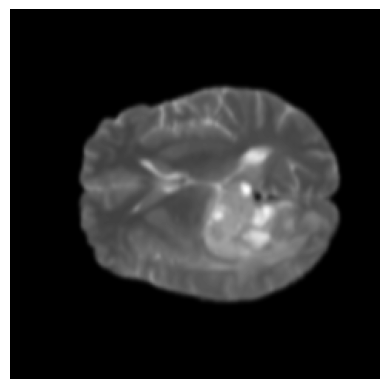

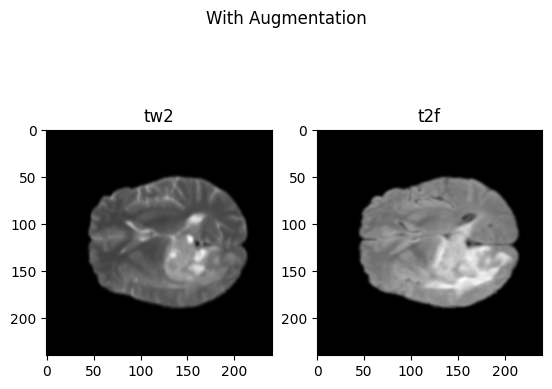

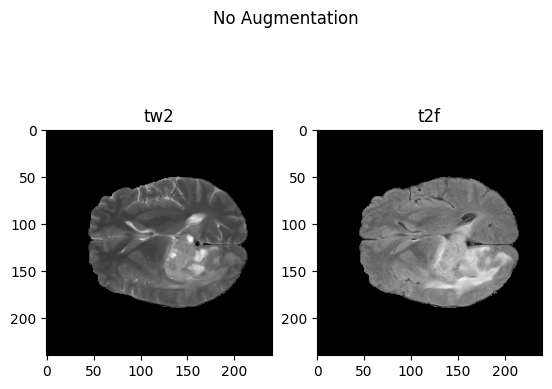

In [22]:
def print_files(x, Aug_index, patient_index):
    # Get a list of all the folders in the specified directory path
    folders = [folder for folder in os.listdir(x) if os.path.isdir(os.path.join(x, folder))]

    # Randomly select a folder from the list
    selected_folder = random.choice(folders)

    print(selected_folder)
    # Get the complete path of the selected folder
    selected_folder_path = os.path.join(x, selected_folder)

    # Get a list of all the files inside the selected folder
    files = os.listdir(selected_folder_path)
    print(files)
    #random_number = random.randint(0, 61)
    #use_file = random.choice(files)

    # list of patients
    patient_num = ["BraTS-GLI-01442-000", "BraTS-GLI-00090-000", "BraTS-GLI-00445-000", "BraTS-GLI-00642-000", "BraTS-GLI-00828-000"]

    #######################
    ##### change the index to choose a patient
    use_file = patient_num[patient_index] # change the value to indicate which patient you are interested in
    ######################

    selected_subfolder_path = os.path.join(x, selected_folder, use_file)
    dir_list = os.listdir(selected_subfolder_path)
    SSA_data = "/content/sample_data/GLI_data"
    if not os.path.exists(SSA_data):
      os.mkdir(SSA_data)

    labels_SSA = []
    SSA_loop = []
    before = [] # initiate list of images
    for item in dir_list:
      print(item)
      item_path = os.path.join(selected_subfolder_path, item)
      print(item_path)
      if os.path.isfile(item_path):
        GLI_image = tio.ScalarImage(item_path) #converts to 4D tensor

        base_name = os.path.basename(item_path)
        base_name_without_extension = base_name[:-7]
        parts = base_name_without_extension.split("-")
        other = base_name_without_extension.split("-")
        mod_type = parts[-1]
        Patient = other[-3]
        print(Patient)

        ## keep track of images without Augmentations
        img = nib.load(item_path)
        data_before = np.array(img.dataobj) # this line is so that we can keep track of the images without Augs
        image_before = data_before[ :, :, 75]
        plt.imshow(image_before, cmap='gray')
        plt.axis('off')
        plt.savefig(os.path.join(SSA_data + "-" + Patient + "-" +  mod_type + '.png'))

        before.append(image_before)

        # different augmentations
        flipR = tio.RandomFlip(axes=(0, 1, 2), p=0.8)
        resampleR = tio.Resample((1.2, 1.2, 6))
        anisoR = tio.RandomAnisotropy(axes=(0, 1, 2), downsampling=(1, 6))
        blurR = tio.RandomBlur(std=(0.5, 1.5))
        noiseR = tio.RandomNoise(mean=0, std=(0, 0.33))
        motionR = tio.RandomMotion(num_transforms=3, image_interpolation='nearest')
        biasfR = tio.RandomBiasField(coefficients=1)
        ghostR = tio.RandomGhosting(intensity=1.5)

            # creating a dictionary for the different augmentations
        Augs = {1: flipR, 2: resampleR, 3: anisoR, 4: blurR, 5: noiseR, 6: motionR, 7: biasfR, 8: ghostR}
        # NB !! Rememebr to change the Aug_index depending on the Aug you choose.


        #change the index depending on the Aug used
        ########################################################
        #Aug_index = 4
        #########################################################


        transform = Augs[Aug_index] # choose the axis to flip (x,y,z) used p=0.3 initially

        transformed_image = transform(GLI_image)
        transformed_new = np.squeeze(transformed_image)
        data = np.array(transformed_new)



        #nifti_data = nifti_file.get_fdata()
        image = data[ :, :, 75]
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        plt.savefig(os.path.join(SSA_data + "-" + Patient + "-" +  mod_type + '.png'))
        #plt.show()

        SSA_loop.append(image)

        labels_SSA.append(mod_type)
        print(labels_SSA)
        list_paths = ["/content/sample_data/RandomFlip_GLI/", "/content/sample_data/Resample_GLI/", "/content/sample_data/AnisoR_GLI/", "/content/sample_data/BlurR_GLI/", "/content/sample_data/NoiseR_GLI/", "/content/sample_data/MotionR_GLI/", "/content/sample_data/BiasFieldR_GLI/", "/content/sample_data/ghostR_GLI/"]
        # remember to change the index depending on the Aug you choose
        subplot_path = list_paths[Aug_index - 1]
        if not os.path.exists(subplot_path):
          os.mkdir(subplot_path)
            #label_mod = ["t2w", "t2f"]
        if len(labels_SSA) > 4:
          mod_t2w = labels_SSA.index("t2w")
          mod_t2f = labels_SSA.index("t2f")

          # Display the images WITH Augmentations
          fig, ax = plt.subplots(1,2)
          ax[0].imshow(SSA_loop[mod_t2w], cmap = "gray")
          ax[1].imshow(SSA_loop[mod_t2f], cmap = "gray")
          ax[0].set_title("tw2")
          ax[1].set_title("t2f")
          plt.suptitle("With Augmentation")
          plt.savefig(os.path.join(subplot_path + "GLI" + "-" +  Patient +  '.png'), bbox_inches='tight')
          plt.show()

          # Display the imageS WITHOUT Augmentations
          fig, ax = plt.subplots(1,2)
          ax[0].imshow(before[mod_t2w], cmap = "gray")
          ax[1].imshow(before[mod_t2f], cmap = "gray")
          ax[0].set_title("tw2")
          ax[1].set_title("t2f")
          plt.suptitle("No Augmentation")
          plt.savefig(os.path.join(subplot_path + "GLI" + "-" +  Patient +  '.png'), bbox_inches='tight')
          plt.show()




# enter a numerical value depending on the patient you are interested in:
#############################################
#Choose patient
#0 - "BraTS-GLI-01442-000"
#1 - "BraTS-GLI-00090-000"
#2 - "BraTS-GLI-00445-000"
#3 - "BraTS-GLI-00642-000"
#4 - "BraTS-GLI-00642-000"

# choose augmentation
#1: flipR
#2: resampleR
#3: anisoR
#4: blurR
#5: noiseR
#6: motionR
#7: biasfR
#8: ghostR
###############################################
# print_files (dir, Aug_index, Patient_index)
print_files(GLI_dir, 4, 2)








In [ ]:


# Load the image
image = tio.ScalarImage('/content/sample_data/GLI_data/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/BraTS-GLI-00000-000/BraTS-GLI-00000-000-t2w.nii.gz')

# Apply RandomFlip transformation
transform = tio.RandomFlip(axes=(0, 1))
transformed_image = transform(image)
new = np.squeeze(transformed_image)
print(new.shape)

# Print the transformed image
#print(transformed_image.shape)
#convert = np.array(transformed_image)
#print(convert)




(240, 240, 155)
